In [1]:
%load_ext autoreload
%autoreload 2

In [108]:
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage, stats
import pandas as pd
from astropy import table, coordinates
from astropy import units as u
from astropy.io import fits
from astropy import cosmology
import sep
from astrodendro import Dendrogram

from ekfplot import plot as ek
from ekfplot import colors as ec
from ekfphys import observer
from ekfstats import imstats, fit, sampling, functions

from carpenter import conventions

import reader

In [3]:
cosmo = cosmology.FlatLambdaCDM(70.,0.3)

merian = table.Table(fits.getdata('../local_data/inputs/Merian_DR1_photoz_EAZY_v1.2.fits',1))
mcoords = coordinates.SkyCoord( merian['coord_ra_Merian'], merian['coord_dec_Merian'], unit='deg')
merian_sources, galex = reader.get_meriancrossgalex (merian)

[merianselect] Only choosing sources at 0.070<z_phot<0.090
[merianselect] Only choosing sources with i_cModelmag_Merian < 22.0
[merianselect] only choosing sources with cmodel/gaap(i) > 1.3


In [100]:
catalog_halum = pd.read_csv ( '/Users/kadofong/Desktop/merian_catalog_halum.csv', index_col=0)
merian_lha_df = pd.read_csv('../local_data/output/lha_df.csv', index_col=0).dropna()
#merian_lha_df = merian_lha_df.reindex(merian_sources.index)

In [101]:
fn = lambda x: conventions.produce_merianobjectname(x['RA'], x['DEC'], )
merian_sources['objname'] = merian_sources.apply(fn, axis=1)

In [192]:
sbdf = pd.DataFrame(
    index=merian_lha_df.index,
    columns=['r_eff','n','r_eff_psf','n_psf']
)


for mid in merian_sources.index:
    row = merian_sources.loc[mid]
    wid = conventions.produce_merianobjectname(
        ra=merian_sources.loc[mid,'RA'],
        dec=merian_sources.loc[mid,'DEC']
    )

    #print(merian_sources.loc[mid,'RA'],merian_sources.loc[mid,'DEC'])
    redshift = row['z_phot']
    filename = f'/Users/kadofong/work/projects/merian/agrias/local_data/cutouts/halpha/{wid}.fits'
    if not os.path.exists(filename):
        continue
    
    x = fits.open(filename)
    img = x[0].data.astype(np.float64)
    
    psf = fits.open('../local_data/cutouts/merian/J000004.79+003359.58_N708_merpsf.fits')[0].data
    
    i_std = np.std(stats.sigmaclip(functions.fmasker(img)[0]).clipped)
    #ek.imshow(np.where(segmap>0, np.random.normal(0.,i_std,img.shape), img))
    
    #cat, segmap = sep.extract(img, thresh=3, err=i_std, deblend_cont=1., segmentation_map=True)
    #centralid = imstats.get_centerval(segmap)
    
    pixscale = 0.168 * u.arcsec
    sky_to_phys = (pixscale * cosmo.kpc_proper_per_arcmin(redshift)).to(u.kpc).value
    init_r_eff = 1./sky_to_phys
    model, pred = fit.fit_sersic_2d(img, init_r_eff=init_r_eff )
    model
    
    Y,X = np.mgrid[:img.shape[0],:img.shape[1]]
    X_c = (X - model.x_0)
    Y_c = (Y - model.y_0)
    X_rot, Y_rot = imstats.rotate_coordinates( X_c, Y_c, np.pi-model.theta )
    Y_rot /=  1. - model.ellip
    R = np.sqrt(X_rot**2 + Y_rot**2) + 0.0001
    
    R_phys = R*sky_to_phys
    
    R_psf = imstats.build_xygrid(psf.shape) * sky_to_phys
    
    gr = -2.5*np.log10(row['g_gaap1p0Flux_aperCorr_Merian']/row['r_gaap1p0Flux_aperCorr_Merian'])
    apercorr = row['i_cModelFlux_Merian']/row['i_gaap1p0Flux_aperCorr_Merian']
    rmag = -2.5*np.log10(row['r_gaap1p0Flux_aperCorr_Merian'] * apercorr) + 31.4
    Mr = rmag - observer.photometric_kcorrection(gr,redshift) - cosmo.distmod(redshift).value
    
    fig, axarr = plt.subplots(1,2,figsize=(12,5))
    
    ax = axarr[0]
    ek.imshow(img, q=5e-3, ax=ax, cmap='magma')
    ek.contour(R_phys, colors='w', linestyles=':', levels=np.array([1.,5., 10.]), ax=ax)#labels=['1','5','10'])
    ek.text(
        0.025,
        0.975,
        r'''${\rm log_{10}(M_\star/M_\odot)=%.2f}$
$M_r = %.1f$''' % (row['logmass_gaap1p0'],Mr),
        color='w',
        ax=ax
    )
    ax.set_xlim(50,200)
    ax.set_ylim(50,200)

    _rbins = np.arange(2.,40.,1)
    rbins = _rbins  * sky_to_phys
    
    bx = axarr[1]
    _,(cts,_,patches) = ek.hist(
        R_phys,
        weights=(img/(2.*np.pi*R_phys)).flatten(), 
        bins=rbins,
        alpha=0.1,
        lw=2,
        ax=bx
    )
    
    psf_cts,_=np.histogram(
        R_psf.flatten(),
        weights=(psf/(2.*np.pi*R_psf)).flatten(),
        bins=rbins,
    )
    
    psf_normalizer = np.nanmax(cts)/np.nanmax(psf_cts)
    ek.hist(
        R_psf.flatten(),
        weights=(psf_normalizer*psf/(2.*np.pi*R_psf)).flatten(),
        bins=rbins,
        histtype='step',
        lw=2,
        color='grey',
        zorder=0,
        ax=bx
    )

    npix = np.pi*(_rbins[1:]**2-_rbins[:-1]**2)
    bx.plot(sampling.midpts(rbins), i_std/np.sqrt(npix), color='k')
    bx.axhline(i_std, color='k')
    bx.set_yscale('log')
    bx.set_ylim( i_std/np.sqrt(npix.max()), plt.ylim()[1])
    bx.set_xlabel('a [kpc]')
    bx.set_ylabel(r'SB$_{\rm H\alpha}$ [erg s$^{-1}$ kpc$^{-2}$]')

    rmid = sampling.midpts(rbins)
    try:
        s1d_model, s1d_pred = fit.fit_sersic_1d(*functions.fmasker(rmid, cts), 
                                                init_r_eff=2., init_const=i_std)
        psf_model, psf_pred = fit.fit_sersic_1d(*functions.fmasker(rmid, psf_cts*psf_normalizer), 
                                                init_r_eff=0.5, init_const=i_std)
        sbdf.loc[mid, 'r_eff'] = s1d_model.r_eff_0.value
        sbdf.loc[mid, 'n'] = s1d_model.n_0.value
        sbdf.loc[mid, 'r_eff_psf'] = psf_model.r_eff_0.value
        sbdf.loc[mid, 'n_psf'] = psf_model.n_0.value  

        sbdf.loc[mid, 'A'] = np.log10(s1d_pred[0])
        sbdf.loc[mid, 'i_std'] = np.log10(i_std)

        bx.plot ( functions.fmasker(rmid, cts)[0], s1d_pred, color='C0', lw=3 )
        bx.plot ( functions.fmasker(rmid, psf_cts)[0], psf_pred, color='grey', lw=3 )
        bx.axvline ( s1d_model.r_eff_0.value, color='C0', ls='--', lw=3 )
        bx.axvline ( psf_model.r_eff_0.value, color='grey', ls='--', lw=1.5 )
        #bx.set_xlim(0., functions.fmasker(rmid, cts)[0].max())

        ek.contour(R_phys, colors=ec.ColorBase('C0').modulate(0.2,0.3).hex_base, levels=np.array([s1d_model.r_eff_0.value]), ax=ax)

    except:
        pass

    plt.savefig(f'/Users/kadofong/Desktop/figures/{mid}.png')
    plt.close()
    #print(f'Processed {mid}')

sbdf['snr'] = 10.**(sbdf['A'] - sbdf['i_std'])

/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/site-packages/astropy/modeling/functional_models.py:3292: RuntimeWarning: divide by zero encountered in divide
  z = np.sqrt((x_maj / a) ** 2 + (x_min / b) ** 2)
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/site-packages/astropy/modeling/functional_models.py:858: RuntimeWarning: divide by zero encountered in divide
  -cls._gammaincinv(2 * n, 0.5) * ((r / r_eff) ** (1 / n) - 1)
/var/folders/fs/f3k7bp2n3k1bldhn58thddt40000gn/T/ipykernel_72721/2863054804.py:88: RuntimeWarning: All-NaN slice encountered
  psf_normalizer = np.nanmax(cts)/np.nanmax(psf_cts)
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/site-packages/astropy/modeling/functional_models.py:3292: RuntimeWarning: divide by zero encountered in divide
  z = np.sqrt((x_maj / a) ** 2 + (x_min / b) ** 2)
/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/site-packages/astropy/modeling/functional_models.py:858: RuntimeWarning: divide by zero e

NonFiniteValueError: Objective function has encountered a non-finite value, this will cause the fit to fail!
Please remove non-finite values from your input data before fitting to avoid this error.

In [199]:
sbdf

,r_eff,n,r_eff_psf,n_psf,A,i_std
M3324848395603966290,5.506393,0.5,1.632478,10.0,36.756827,37.155378
M3324852793650467962,2.582419,4.080449,1.80387,10.0,38.592722,37.276715
M3324857191696979637,0.971343,0.962111,1.007645,0.986455,37.944666,37.122655
M3324865987790013450,1.161669,1.294516,1.005345,0.986456,38.987599,37.071002
M3324887978022557647,4.89698,0.5,1.024627,0.986456,37.846480,37.126629
...,...,...,...,...,...,...
M3235730779149469980,2.598701,2.735615,1.611734,10.0,37.498621,37.196484
M3320256835046367631,0.0,0.5,1.349239,10.0,37.406061,37.132924
M3320349194023097501,1.044724,0.5,1.375678,10.0,37.807204,37.195864
M3503738937443104285,0.179461,0.5,1.057365,0.986456,31.288330,37.242777


In [207]:
extended = (10.**(sbdf['A']-sbdf['i_std']) > 3.)&(sbdf['n']>0.5)&(sbdf['n']<4.)&(sbdf['r_eff']>(2.*sbdf['r_eff_psf']))

In [214]:
mid = 'M3503796112047765912'
print(extended.loc[mid])
sbdf.loc[mid]

True


r_eff           5.3851
n             1.737108
r_eff_psf     1.616083
n_psf             10.0
A            38.105945
i_std        37.330558
Name: M3503796112047765912, dtype: object

In [221]:
sbdf.loc[extended, 'A'].shape

(280,)

Text(0, 0.5, 'n')

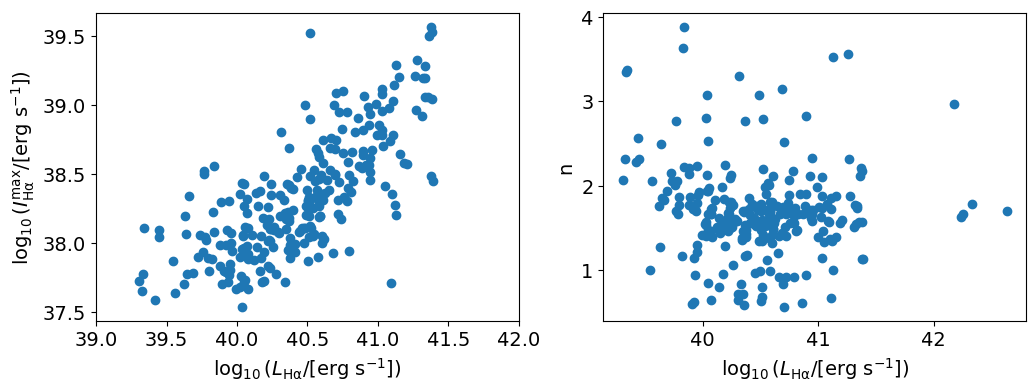

In [231]:
fig, axarr = plt.subplots(1,2,figsize=(12,4))
ax = axarr[0]
ax.scatter(
    np.log10(merian_lha_df.reindex(sbdf.loc[extended].index)['LHa'])+40.,
    sbdf.loc[extended, 'A']
)
ax.set_xlabel(r'$\log_{10}(L_{\rm H\alpha}/[\rm erg\ s^{-1}])$')   
ax.set_ylabel(r'$\log_{10}(I^{\rm max}_{\rm H\alpha}/[\rm erg\ s^{-1}])$')
ax.set_xlim(39.,42.)
bx = axarr[1]
bx.scatter(
    np.log10(merian_lha_df.reindex(sbdf.loc[extended].index)['LHa'])+40.,
    sbdf.loc[extended, 'n']
)
bx.set_xlabel(r'$\log_{10}(L_{\rm H\alpha}/[\rm erg\ s^{-1}])$') 
bx.set_ylabel('n')

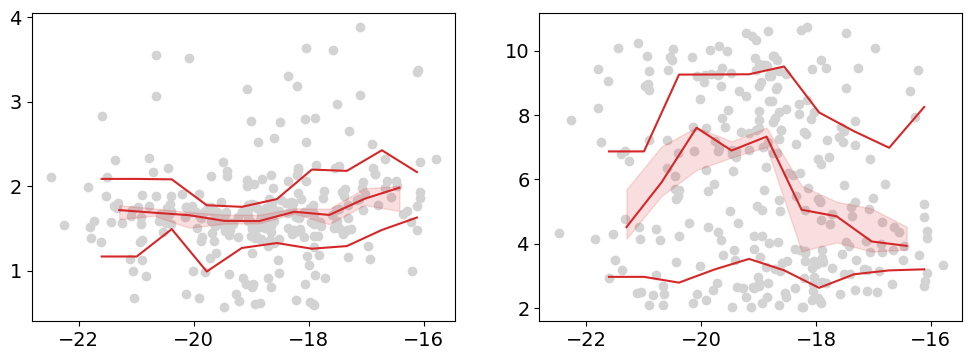

In [212]:
fig, axarr = plt.subplots(1,2,figsize=(12,4))

ax = axarr[0]
im = ax.scatter(
    #merian_sources.reindex(sbdf.index).loc[extended, 'i_cModelmag_Merian'],    
    merian_sources.reindex(sbdf.index).loc[extended, 'Mi'],
    sbdf.loc[extended,'n'],
    color='lightgrey',
)
ek.running_quantile(
    merian_sources.reindex(sbdf.index).loc[extended, 'Mi'],
    sbdf.loc[extended,'n'],
    bins=10,
    ax=ax,
    erronqt=True,
    color='tab:red',
    err_format='fill_between'
)

ax = axarr[1]
im = ax.scatter(
    #merian_sources.reindex(sbdf.index).loc[extended, 'i_cModelmag_Merian'],    
    merian_sources.reindex(sbdf.index).loc[extended, 'Mi'],
    sbdf.loc[extended,'r_eff'],
    color='lightgrey',
)
_=ek.running_quantile(
    merian_sources.reindex(sbdf.index).loc[extended, 'Mi'],
    sbdf.loc[extended,'r_eff'],
    bins=10,
    ax=ax,
    erronqt=True,
    color='tab:red',
    err_format='fill_between'
)
#ax.set_yscale('log')
#plt.colorbar(im, ax=ax, label=r'$M_i$')
#ax.set_ylim(0.,2.5)

In [172]:
row = sbdf.loc['M3037018241684749214']
print(np.log10(row.A))

37.44777423669638


In [256]:
froma astropy.modeling.models import Sersic1D, Const1D

In [263]:
rmask = R_phys < 15.
s1d_model, s1d_pred = fit.fit_sersic_1d(R_phys[rmask], img[rmask], init_r_eff=2., init_const=i_std)
psf_model, psf_pred = fit.fit_sersic_1d(R_psf, psf, init_r_eff=0.5, init_const=i_std)

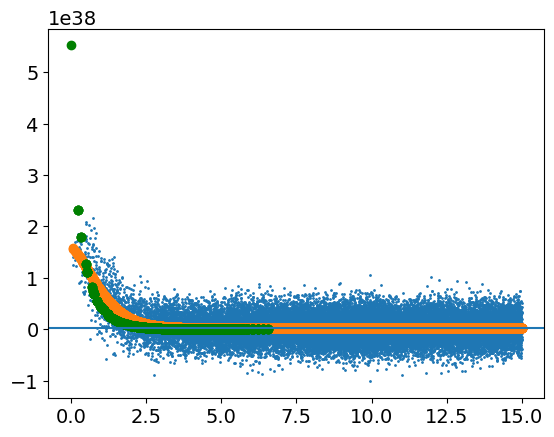

In [302]:
out = R_phys > 5.
plt.scatter ( R_phys[rmask], img[rmask], s=1)
plt.scatter ( R_phys[rmask], s1d_pred)
plt.scatter ( R_psf.flatten(), psf_pred.flatten()*s1d_model.amplitude_0/psf_model.amplitude_0, color='g')
plt.axhline(np.median(img[out]))
#plt.yscale('log')